In [1]:
import pandas as pd
import numpy as np
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8

In [2]:
original_df = pd.read_csv("/content/drive/MyDrive/NUS/financial dataset.csv")

In [3]:
original_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df = pd.get_dummies(original_df, columns=['type'], prefix=['type'], drop_first=True)
df.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,0,1,0
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,0,1,0
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,0,0,1
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1,0,0,0
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,0,1,0


In [6]:
df.isnull().values.any()

False

Text(0.5, 1.0, 'Count of Fradulent and Non-Fraudulent Transactions')

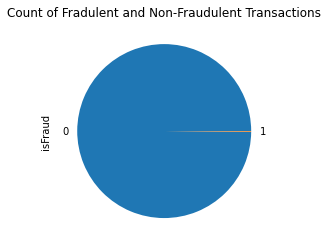

In [7]:
fraud_count = pd.value_counts(df['isFraud'], sort=True)
fraud_count.plot(kind = 'pie')
plt.title("Count of Fradulent and Non-Fraudulent Transactions")

In [8]:
fraud_count

0    6354407
1       8213
Name: isFraud, dtype: int64

In [9]:
fraud = df[df['isFraud']==1]
normal = df[df['isFraud']==0]

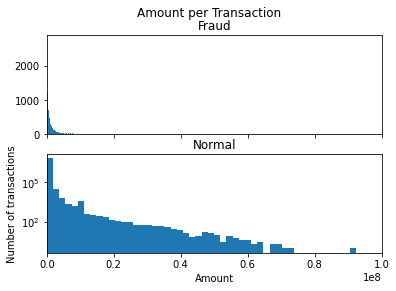

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per Transaction')

ax1.hist(fraud['amount'], bins=50)
ax1.set_title('Fraud')
ax2.hist(normal['amount'], bins=50)
ax2.set_title('Normal')
plt.xlabel('Amount')
plt.ylabel('Number of transactions')
plt.xlim((0, 100000000))
plt.yscale('log')

In [11]:
df.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,0,1,0
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,0,1,0
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,0,0,1
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1,0,0,0
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,0,1,0


In [12]:
X = df.drop(columns=['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest', 'newbalanceOrig', 'newbalanceDest'])
Y = df['isFraud']

In [13]:
outlier_fraction = len(fraud)/float(len(normal))

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
}

In [ ]:
n_outliers = len(fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


Isolation Forest: 12755
Accuracy Score :
0.9979953226815369
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   6354407
           1       0.22      0.22      0.22      8213

    accuracy                           1.00   6362620
   macro avg       0.61      0.61      0.61   6362620
weighted avg       1.00      1.00      1.00   6362620

Local Outlier Factor: 16241
Accuracy Score :
0.9974474351760753
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   6354407
           1       0.01      0.01      0.01      8213

    accuracy                           1.00   6362620
   macro avg       0.51      0.51      0.51   6362620
weighted avg       1.00      1.00      1.00   6362620



Conclusion:

Isolation Forest has performed the best, with an accuray score of 99.80%, and a a macro average precision of 61%, much better than the other 2 models.

Perhaps more deep learning algorithms can be carried out to obtain a more accurate detection of fradulent cases.